In [1]:
%matplotlib inline

import os
import shutil
import matplotlib.pyplot as plt
import tridesclous as tdc

## DataIO

In [2]:
path_wd = 'C:\\Users\\user\\Documents\\Bodo_Rueckauer\\Data\\raw\\Spont'
path_out = os.path.join(path_wd, 'Spont_tdc')

if os.path.exists(path_out):
    shutil.rmtree(path_out)   

dataio = tdc.DataIO(path_out)

path_data = os.path.join(path_wd, 'Spont.mcd')
dataio.set_data_source(type='mcd', filenames=[path_data])
print(dataio)

Converting file from .mcd to .h5: C:\Users\user\Documents\Bodo_Rueckauer\Data\raw\Spont\Spont.mcd
Done.
Loading .h5 file: C:\Users\user\Documents\Bodo_Rueckauer\Data\raw\Spont\Spont.h5
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (60, 5915000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (60,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (3, 5915000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (3,), type "|V108">
100.00%
Done.
Finished initializing DataSource.
DataIO <id: 1505681821448> 
  workdir: C:\Users\user\Documents\Bodo_Rueckauer\Data\raw\Spont\Spont_tdc

In [25]:
path_probe = os.path.join(path_out, 'Spont.prb')

probe_string = ('''\
n_electrodes = 60
channel_groups = {0: {'channels': list(range(n_electrodes)), 
                      'geometry': {k: [0, k * 200] for k in range(n_electrodes)}}}
''')

with open(path_probe, 'w') as f:
    f.write(probe_string)
    
dataio.set_probe_file(path_probe)

## CatalogueConstructor

In [26]:
catalogueconstructor = tdc.CatalogueConstructor(dataio)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  Signal pre-processing not done yet


In [27]:
catalogueconstructor.set_preprocessor_params(highpass_freq=100, 
                                             lowpass_freq=5000, 
                                             relative_threshold=4)

## Median and MAD per channel

In [28]:
catalogueconstructor.estimate_signals_noise()
print(catalogueconstructor.signals_medians)
print(catalogueconstructor.signals_mads)

[ 4.7660674e-08  1.1907502e-07  1.5079175e-07  2.5945292e-08
  4.9975290e-07  1.5903963e-07  3.4921700e-07  3.2884395e-07
  2.7995549e-07  4.4636419e-09  2.4753791e-07  2.5746456e-07
  1.2902154e-07 -1.3814805e-09  4.8641748e-09  9.6480353e-09
  4.3113482e-07  8.0723481e-08  3.5107252e-07  3.3025356e-07
  3.2452851e-07  5.5401784e-07  5.3569977e-07  3.3666374e-09
 -7.1834645e-09  6.2195323e-07  3.0115648e-09  9.4256896e-09
 -9.0939452e-09  6.2503648e-07  5.2409507e-07  4.9599726e-07
  7.9111985e-08 -2.3748488e-09  7.4823487e-07  9.2376757e-07
  7.3393085e-07  3.3761671e-07  7.4298993e-07  9.5925009e-07
  6.0988918e-07  7.0368179e-07  2.3224059e-07  4.4518322e-07
  1.5334321e-07  6.2176582e-07  4.5431733e-07  4.5686710e-07
  2.7689595e-07  4.2132118e-07  1.4928102e-07  1.5475359e-07
  3.7704012e-07  2.9662650e-09  3.2023493e-07  2.9816698e-07
  1.6317456e-08  3.2922607e-08  7.5519914e-08  3.7081767e-07]
[4.2190472e-06 4.3413929e-06 4.5269267e-06 7.8799576e-06 5.2970699e-06
 4.5105421e-0

## Signal preprocessing and peak detection

In [29]:
catalogueconstructor.run_signalprocessor(duration=100)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  cluster_labels [-11]



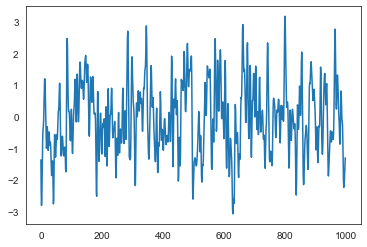

In [30]:
plt.plot(dataio.arrays[0][0].get('processed_signals')[:1000, 0])

## Extract a few waveforms

In [31]:
catalogueconstructor.extract_some_waveforms(wf_left_ms=-2, wf_right_ms=3)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  cluster_labels [-11   0]



## Remove outlier spikes

In [32]:
catalogueconstructor.clean_waveforms()
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  cluster_labels [-11   0]



## Feature extraction

In [33]:
# catalogueconstructor.extract_some_features(method='pca_by_channel',
#                                            n_components_by_channel=4)
catalogueconstructor.extract_some_features(method='neighborhood_pca',
                                           n_components_by_neighborhood=4,
                                           radius_um=300)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  some_features.shape: (9628, 240)
  cluster_labels [-11   0]



## Clustering

In [34]:
catalogueconstructor.find_clusters(method='gmm', n_clusters=3)
print(catalogueconstructor)

CatalogueConstructor
  chan_grp 0 - ch47 ch48 ch46 ... ch58 ch57
  nb_peak_by_segment: 131520
  some_waveforms.shape: (9628, 125, 60)
  some_features.shape: (9628, 240)
  cluster_labels [-11   0   1   2]



## Visual check in CatalogueWindow

In [35]:
%gui qt5
import pyqtgraph as pg
app = pg.mkQApp()
win = tdc.CatalogueWindow(catalogueconstructor)
win.show()
app.exec_()    

Exception: Plot data must be 1D ndarray.

0

## Peeler

In [ ]:
catalogueconstructor.make_catalogue_for_peeler()
initial_catalogue = dataio.load_catalogue()

peeler = tdc.Peeler(dataio)
peeler.change_params(initial_catalogue)

peeler.run()

print("Number of spikes: {}".format(dataio.get_spikes(0).size))

## Visual check in PeelerWindow

In [ ]:
%gui qt5
import pyqtgraph as pg
app = pg.mkQApp()
win = tdc.PeelerWindow(dataio=dataio, catalogue=initial_catalogue)
win.show()
app.exec_()